In [14]:
import numpy
import time
import tqdm
import ipyparallel as ipp
import qiskit.providers.aer.noise as noise
from scipy.stats import multinomial
from scipy import stats
import qiskit
from joblib import Parallel, delayed,Memory
from mitiq import zne
import mitiq
from mitiq.zne.scaling import fold_gates_from_left,fold_gates_at_random, fold_global,fold_gates_from_right
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyFactory
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
#from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.chemistry import FermionicOperator
from qiskit.providers.aer import AerSimulator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from joblib import Parallel, delayed
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD

In [15]:
#device_backend = FakeManhattan()
#sim_manhattan = AerSimulator.from_backend(device_backend)

In [16]:
import warnings
warnings. filterwarnings('ignore')

In [17]:
c =ipp.Client()
num_qubits=8

In [18]:
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [19]:
def auxHamiltonianEnergy(circ,U=7):
    #construct Hamiltonian
    def qubitOp(h1,h2):
        qubit_op=FermionicOperator(h1,h2).mapping('jordan_wigner')
        return qubit_op
    def egBandHamiltonian(U):
        #Getting chemical Potential for Half-Filling
        with open('../chem_pot_for_Half_Fill.txt','r') as f:
            lines=f.readlines()[1:]
            for line in lines:
                elems=line.split()
                if int(elems[0])==U:
                    muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
        #Getting the one body and two body interaction vertexes
        with open('../'+str(U)+'/v1e.dat','r') as f:
                lines=f.readlines()[1:]
                num_sites=4
                chem_pot=numpy.zeros((2*num_sites,2*num_sites))
                eg_h1=numpy.zeros((2*num_sites,2*num_sites))
                for line in lines:
                    elems=line.split()
                    eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                    eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
                for i in range(2*num_sites):
                    chem_pot[i][i]=-muHalf
                eg_h1=eg_h1+chem_pot       
        with open('../'+str(U)+'/v2e.dat','r') as f:
            num_sites=4
            eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
            for line in f:
                if "#" in line:
                    continue
                line = line.split()
                i,j,k,l = map(int, line[:4])
                val = float(line[4])
                eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites]             = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
        qubitH=qubitOp(eg_h1,eg_h2)
        Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix
        w,v=numpy.linalg.eigh(Hmat)
        Eg=w[0]
        state_g=v[:,0]
        return qubitH,Hmat,Eg,state_g
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)
    E=numpy.conjugate(state)@Hmat@state
    return E
def PauliStringToMatrix(Label):
    Label1=numpy.array(list(Label))
    LabelInds=numpy.where(Label1!='I')[0]
    substring=''.join(list(Label1[LabelInds]))
    UnitaryMat=Pauli(substring).to_matrix()
    return [UnitaryMat,LabelInds]
def UnitaryMatrixForm(data):
    import numpy
    PaulisAndMats,params,ind=data
    Label=PaulisAndMats[ind][0]
    UnitaryMat,qubits_to_act_on=PaulisAndMats[ind][1]
    UnitaryMatrix=numpy.cos(params[ind])*numpy.eye(2**len(qubits_to_act_on))-1j*numpy.sin(params[ind])*UnitaryMat
    return [UnitaryMatrix,qubits_to_act_on[::-1],Label]
def ansatz_circuit(PaulisAndMats,params):
    circ=HFcirc.copy()
    circ=qiskit.transpile(circ,basis_gates=["u1", "u2", "u3", "cx"])
    if(len(PaulisAndMats)!=0):
        inp_data=[(PaulisAndMats,params,i) for i in range(len(params))]
        #result = v1.map_async(UnitaryMatrixForm, inp_data)
        #UnitaryMatArr=result.get()
        UnitaryMatArr=list(map(UnitaryMatrixForm,inp_data))
        for i in range(len(UnitaryMatArr)):
            circ1=QuantumCircuit(8)
            circ1.unitary(UnitaryMatArr[i][0],list(UnitaryMatArr[i][1]),label=UnitaryMatArr[i][2])
            circ1=qiskit.transpile(circ1,basis_gates=["u1", "u2", "u3", "cx"])
            circ=circ+circ1
        del inp_data    
        del UnitaryMatArr
    return circ     
def egBandHamiltonianPartition(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1_0=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1_1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                line=line.split()
                i,j=map(int,line[:2])
                val=float(line[2])
                if(i==j):
                    eg_h1_0[i,j]=eg_h1_0[i+num_sites,j+num_sites]=val
                else:
                    eg_h1_1[i,j]=eg_h1_1[i+num_sites,j+num_sites]=val
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1_0=eg_h1_0+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2_0=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        eg_h2_1=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            if((i==j) and (k==l)):
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k,l] = eg_h2_0[i,j,k+num_sites,l+num_sites] \
                = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
            else:
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
                eg_h2_1[i+num_sites,j+num_sites,k,l] = eg_h2_1[i,j,k+num_sites,l+num_sites] = 0.5*val
    return eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1
def qubitHamiltonianGroups(U):
    def qubitOp(h1,h2):
        fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
        mapper=JordanWignerMapper()
        qubit_op=mapper.map(fer_op)
        return qubit_op
    eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1=egBandHamiltonianPartition(U)
    #grouping-1
    qubitH_0=qubitOp(eg_h1_1,numpy.zeros((8,8,8,8)))
    qubitH_1=qubitOp(eg_h1_0,eg_h2_0)
    qubitH_2=qubitOp(numpy.zeros((8,8)),eg_h2_1)
    #grouping-2
#     qubitH_0=qubitOp(eg_h1_1+eg_h1_0,numpy.zeros((8,8,8,8)))
#     qubitH_1=qubitOp(numpy.zeros((8,8)),eg_h2_0)
#     qubitH_2=qubitOp(numpy.zeros((8,8)),eg_h2_1)
    return qubitH_0,qubitH_1,qubitH_2
def HF_init_state(U,return_MO_rotnOp=False):
    backend=Aer.get_backend('statevector_simulator')
    N=4
    # Qiskit implementation of Givens rotation
    def qubitOp(h1,h2):
        qubit_op=FermionicOperator(h1,h2).mapping('jordan_wigner')
        return qubit_op
    def prepare_givens_rotated_state(givens):
        circ = QuantumCircuit(2*N)
        # Fill first N_f orbitals for each spin
        for i in range(N_f):
            circ.x(i)
            circ.x(i+N)
        for rots in givens:
            for tup in rots:
                #for spin down
                spin=0
                circ.cnot(tup[1]+N*spin,tup[0]+N*spin)
                circ.cry(-2*tup[2],tup[0]+N*spin, tup[1]+N*spin)
                circ.cnot(tup[1]+N*spin, tup[0]+N*spin)
                circ.rz(tup[3],tup[1]+N*spin)
                #for spin up
                spin=1
                circ.cnot(tup[1]+N*spin,tup[0]+N*spin)
                circ.cry(-2*tup[2],tup[0]+N*spin, tup[1]+N*spin)
                circ.cnot(tup[1]+N*spin, tup[0]+N*spin)
                circ.rz(tup[3],tup[1]+N*spin)
        final_state_vector=execute(circ,backend,shots=1024).result().get_statevector()      
        return circ,final_state_vector
    def cost_fn(angles):
        givens=[((1, 2, angles[0], 0.0),), ((0, 1, angles[1], 0.0), (2, 3, angles[2], 0.0)), ((1, 2, angles[3], 0.0),)]  
        #c=Givens_rot_circuit(givens)
        #state = QuantumState(N*2)
        #c.update_quantum_state(state)
        #state_vector=numpy.array(state.get_vector())
        c,state=prepare_givens_rotated_state(givens)
        E=numpy.real(numpy.dot(numpy.dot(numpy.conjugate(state),Hmat),state))
        return E
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot        
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix#qubitH.to_matrix(massive=True)
    E,V=numpy.linalg.eigh(eg_h1)
    energy = 2*sum(E[:int(N/2)])
    psi = V[:,:int(N/2)]
    Q = numpy.transpose(numpy.conjugate(psi))
    N_f=len(Q)
    givens_init = slater_determinant_preparation_circuit(Q)
    params_init=[]
    for k in range(len(givens_init)):
        for l in range(len(givens_init[k])):
            params_init.append(givens_init[k][l][2])        
    res = scipy.optimize.minimize(cost_fn, params_init, bounds=[[-numpy.pi,numpy.pi]]*4,method='L-BFGS-B')
    print("Final Hartree Fock Energy",res['fun'])
    #final slater determinant state vector obtained using quantum variational Hartree Fock using Given Rotations
    params_fin=res['x']
    #Final Givens Rotation Circuit obtained after implementing L-BFGS-B algorithm
    givens_fin=[((1, 2, params_fin[0], 0.0),), ((0, 1, params_fin[1], 0.0), (2, 3, params_fin[2], 0.0)), ((1, 2, params_fin[3], 0.0),)]
    HFcirc,HFstateVec=prepare_givens_rotated_state(givens_fin)
    if return_MO_rotnOp==True:
        givensOp=prepare_given_operator(givens_fin)
        return HFcirc,HFstateVec,givensOp
    return HFcirc,HFstateVec

In [20]:
# def NoiseModel(p_meas=0.01,prob1=0.001,prob2=0.01):
#     # Error probabilities
#     #measurement error
#     error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
#     #prob_1 - 1-qubit gate
#     #prob_2 - 2-qubit gate
#     # Depolarizing quantum errors
#     error_1 = noise.depolarizing_error(prob1, 1)
#     error_2 = noise.depolarizing_error(prob2, 2)
#     # Add errors to noise model
#     noise_model = noise.NoiseModel()
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure")
#     noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#     noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
#     # Get basis gates from noise model
#     basis_gates = noise_model.basis_gates
#     return noise_model,basis_gates
# def NoiseModel(prob1=0.1):
#     # Error probabilities
#     #prob_1 - 1-qubit gate
#     error1 = noise.pauli_error([('X',prob1), ('I', 1 - prob1)])
#     #prob_2 - 2-qubit gate
#     error2 = error1.tensor(error1)
#     # Add errors to noise model
#     noise_model = noise.NoiseModel()
#     noise_model.add_all_qubit_quantum_error(error1, ['x', 'id', 'rx'])
#     noise_model.add_all_qubit_quantum_error(error2, ['cx'])
#     # Get basis gates from noise model
#     basis_gates = noise_model.basis_gates
#     return noise_model,basis_gates
def NoiseModel(prob1=0.1,prob2=0.01):
    # Error probabilities
    #prob_1 - 1-qubit gate
    error1 = noise.pauli_error([('X',prob1), ('I', 1 - prob1)])
    print("one qubit errors")
    print(error1)
    #prob_2 - 2-qubit gate
    error2 = noise.pauli_error([('XX',prob2),('II',1-prob2)])#error1.tensor(error1)
    print("two qubit errors")
    print(error2)
    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error1, ['u1','u2','u3','id'])
    noise_model.add_all_qubit_quantum_error(error2, ['cx'])
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    return noise_model,basis_gates

In [21]:
qr=QuantumRegister(8,'q')

In [51]:

def Energy_Estimator(circ,num_shots_arr=[2**18,2**21,2**20]):
    def qubitOp(h1,h2):
        fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
        mapper=JordanWignerMapper()
        qubit_op=mapper.map(fer_op)
        return qubit_op
    def OffDiag1BodyTerms(Op):
        h1=eg_h1_1#+eg_h1_0
    #     Op=qubitOp(h1,numpy.zeros((8,8,8,8)))
        Op=Op.reduce()
        w,v=numpy.linalg.eigh(h1)
        givens=givensRotns(v.T)[0]
        OpNew=qubitOp(numpy.diag(w),numpy.zeros((8,8,8,8)))
        #Prepare gate implementing Givens Rotn for appending to ansatz circ pre-measurement
        circ=QuantumCircuit(8)
        for rots in givens:
            for tup in rots:
                circ.cnot(tup[1],tup[0])
                circ.cry(-2*tup[2],tup[0], tup[1])
                circ.cnot(tup[1], tup[0])
                circ.rz(tup[3],tup[1])     
        circ0_8gate=circ.to_instruction()
        return circ0_8gate,OpNew
    def OffDiag2BodyTerms(Op):
        theta=numpy.pi/4
        #Prepare UnitaryOp for rotating Hamilotnian terms
        O_0_1_up=(numpy.cos(theta/2.)*I^I^I^I^I^I^I^I)+(1j*numpy.sin(theta/2.)*I^I^I^I^I^I^X^Y)
        O_1_0_up=(numpy.cos(theta/2.)*I^I^I^I^I^I^I^I)+(-1j*numpy.sin(theta/2.)*I^I^I^I^I^I^Y^X)
        O_0_1_down=(numpy.cos(theta/2.)*I^I^I^I^I^I^I^I)+(1j*numpy.sin(theta/2.)*I^I^X^Y^I^I^I^I)
        O_1_0_down=(numpy.cos(theta/2.)*I^I^I^I^I^I^I^I)+(-1j*numpy.sin(theta/2.)*I^I^Y^X^I^I^I^I)
        O_01=O_0_1_up@O_1_0_up@O_0_1_down@O_1_0_down
        O=O_01.reduce()
        Odag=O.adjoint()
        rotH=O@Op@Odag
        rotH=rotH.reduce().reduce()
         #theta=numpy.pi/4
        #Prepare gate implementing Givens Rotn for appending to ansatz circ pre-measurement
        RotMat=(1/numpy.sqrt(2))*numpy.array([[1,-1],[1,1]])
        w,v=numpy.linalg.eigh(RotMat)
        givens=givensRotns(v.T)[0]
        circ=QuantumCircuit(2)
        for rots in givens:
            for tup in rots:
                circ.cnot(tup[1],tup[0])
                circ.cry(-2*tup[2],tup[0], tup[1])
                circ.cnot(tup[1], tup[0])
                circ.rz(tup[3],tup[1])        
        circ0_1gate=circ.to_instruction()
        return circ0_1gate,rotH
    def estimate(PauliOp,counts):
        PauliString,coeff=PauliOp.primitive.to_list()[0]
        indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
        bitstrings,cnts=list(counts. keys()),list(counts.values())
        p=0
        for i in range(len(bitstrings)):
            counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
            if counter_1%2==1:
                p=p+cnts[i]
        p=p/sum(cnts)
        mean=(1-2*p)
        return mean*coeff.real
    def getCounts(Input):
        circ,num_shots=Input
        circ1=circ.copy()
        circ1.add_register(ClassicalRegister(8,'c'))
        circ1.measure([0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7]) 
        job_sim = execute(circ1, AerSimulator(method='density_matrix'),shots=num_shots,basis_gates=basis_gates,noise_model=noise_model,had_transpiled=True) 
        result_sim = job_sim.result()
        density_matrix = result_sim
        counts = result_sim.get_counts(circ1) 
        return counts,density_matrix
    def estimate(PauliOp,counts):
        PauliString,coeff=PauliOp.primitive.to_list()[0]
        indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
        bitstrings,cnts=list(counts. keys()),list(counts.values())
        p=0
        for i in range(len(bitstrings)):
            counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
            if counter_1%2==1:
                p=p+cnts[i]
        p=p/sum(cnts)
        mean=(1-2*p)
        return mean*coeff.real
    def meanOp(PauliOp,counts):
        mean=0
        for i in range(len(PauliOp)):
            mean=mean+estimate(PauliOp[i],counts)
        return mean 
    U=7
    eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1=egBandHamiltonianPartition(U)
    qubitH_0,qubitH_1,qubitH_2=qubitHamiltonianGroups(U)
    opArr=[qubitH_0,qubitH_1,qubitH_2]
    #two body off diags
    circ0_1gate,rotH2Body=OffDiag2BodyTerms(opArr[2])
    #one body off diags
    circ0_8gate,rotH1Body=OffDiag1BodyTerms(opArr[0])
    Ops=[rotH1Body,opArr[1],rotH2Body]
    circ_arr=[circ.copy(),circ.copy(),circ.copy()]
    circ_arr[0].append(circ0_8gate,[0,1,2,3,4,5,6,7])
    circ_arr[2].append(circ0_1gate,[0,1])
    circ_arr[2].append(circ0_1gate,[4,5])
    counts_Arr=Parallel(n_jobs=1,verbose=2)(delayed(getCounts)((circ_arr[i],num_shots_arr[i])) for i in range(len(circ_arr)))
    print(counts_Arr[0][1],counts_Arr[1][1],counts_Arr[2][1])
    m1=meanOp(Ops[0],counts_Arr[0][0])
    m2=meanOp(Ops[1],counts_Arr[1][0])
    m3=meanOp(Ops[2],counts_Arr[2][0])
    return m1+m2+m3

In [52]:
noise_model,basis_gates=NoiseModel(prob1=0.1)#(p_meas=0.0,prob1=0.0001,prob2=0.0001)

one qubit errors
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.1, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.9, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
two qubit errors
QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.01, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(1) = 0.99, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [53]:
U=7
backend=Aer.get_backend('statevector_simulator')
HFcirc,HFstate=HF_init_state(U)
var_form_base=UCCSD(8,4,initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
var_form_base.manage_hopping_operators()
params=[]
with open('../7/FinalDataFiles/adaptVQE-opt-SMO-SV/HF_statevector_adapt_VQE.txt','r') as f:
    lines=f.readlines()
    for i in range(len(lines))[2:]:
        elems=lines[i].split()
        var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(elems[1])]]))
        params.append(float(elems[3]))
circ=var_form_base.construct_circuit(parameters=params)            

Final Hartree Fock Energy -18.788335371650774


In [54]:
compiled = qiskit.transpile(circ,basis_gates=["u1", "u2", "u3", "cx"])

In [55]:
qr=QuantumRegister(8,'q')

In [56]:
Energy_Estimator(HFcirc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Result(backend_name='aer_simulator_density_matrix', backend_version='0.8.1', qobj_id='c278ebc0-4631-43a9-8722-56b616bb24a0', job_id='cae825bc-235b-4833-b7f3-2e7ba1ec4d09', success=True, results=[ExperimentResult(shots=262144, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x62': 511, '0xfa': 487, '0xf2': 516, '0xd0': 617, '0x54': 589, '0xa2': 674, '0xa7': 1222, '0x21': 1158, '0x8a': 1041, '0xc3': 1034, '0x70': 538, '0xec': 621, '0x26': 804, '0x59': 822, '0x76': 538, '0x48': 411, '0x42': 715, '0x89': 1237, '0x77': 1013, '0xe8': 499, '0x84': 960, '0xfb': 605, '0xc7': 1286, '0x5b': 890, '0xa4': 994, '0x8c': 1366, '0xd3': 937, '0x90': 799, '0x50': 739, '0x18': 985, '0xc2': 694, '0xaa': 891, '0x3c': 927, '0x7b': 785, '0xee': 633, '0xa0': 795, '0xf8': 452, '0xe7': 1245, '0xbb': 1428, '0xc4': 857, '0x20': 627, '0xc': 1484, '0xf3': 917, '0xf5': 1028, '0x74': 635, '0x27': 1579, '0x60': 552, '0x1': 1023, '0xa': 1027, '0xef': 819, '0x57': 1146, '0x99': 1682, '0x

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.4s finished


-16.134985485551613

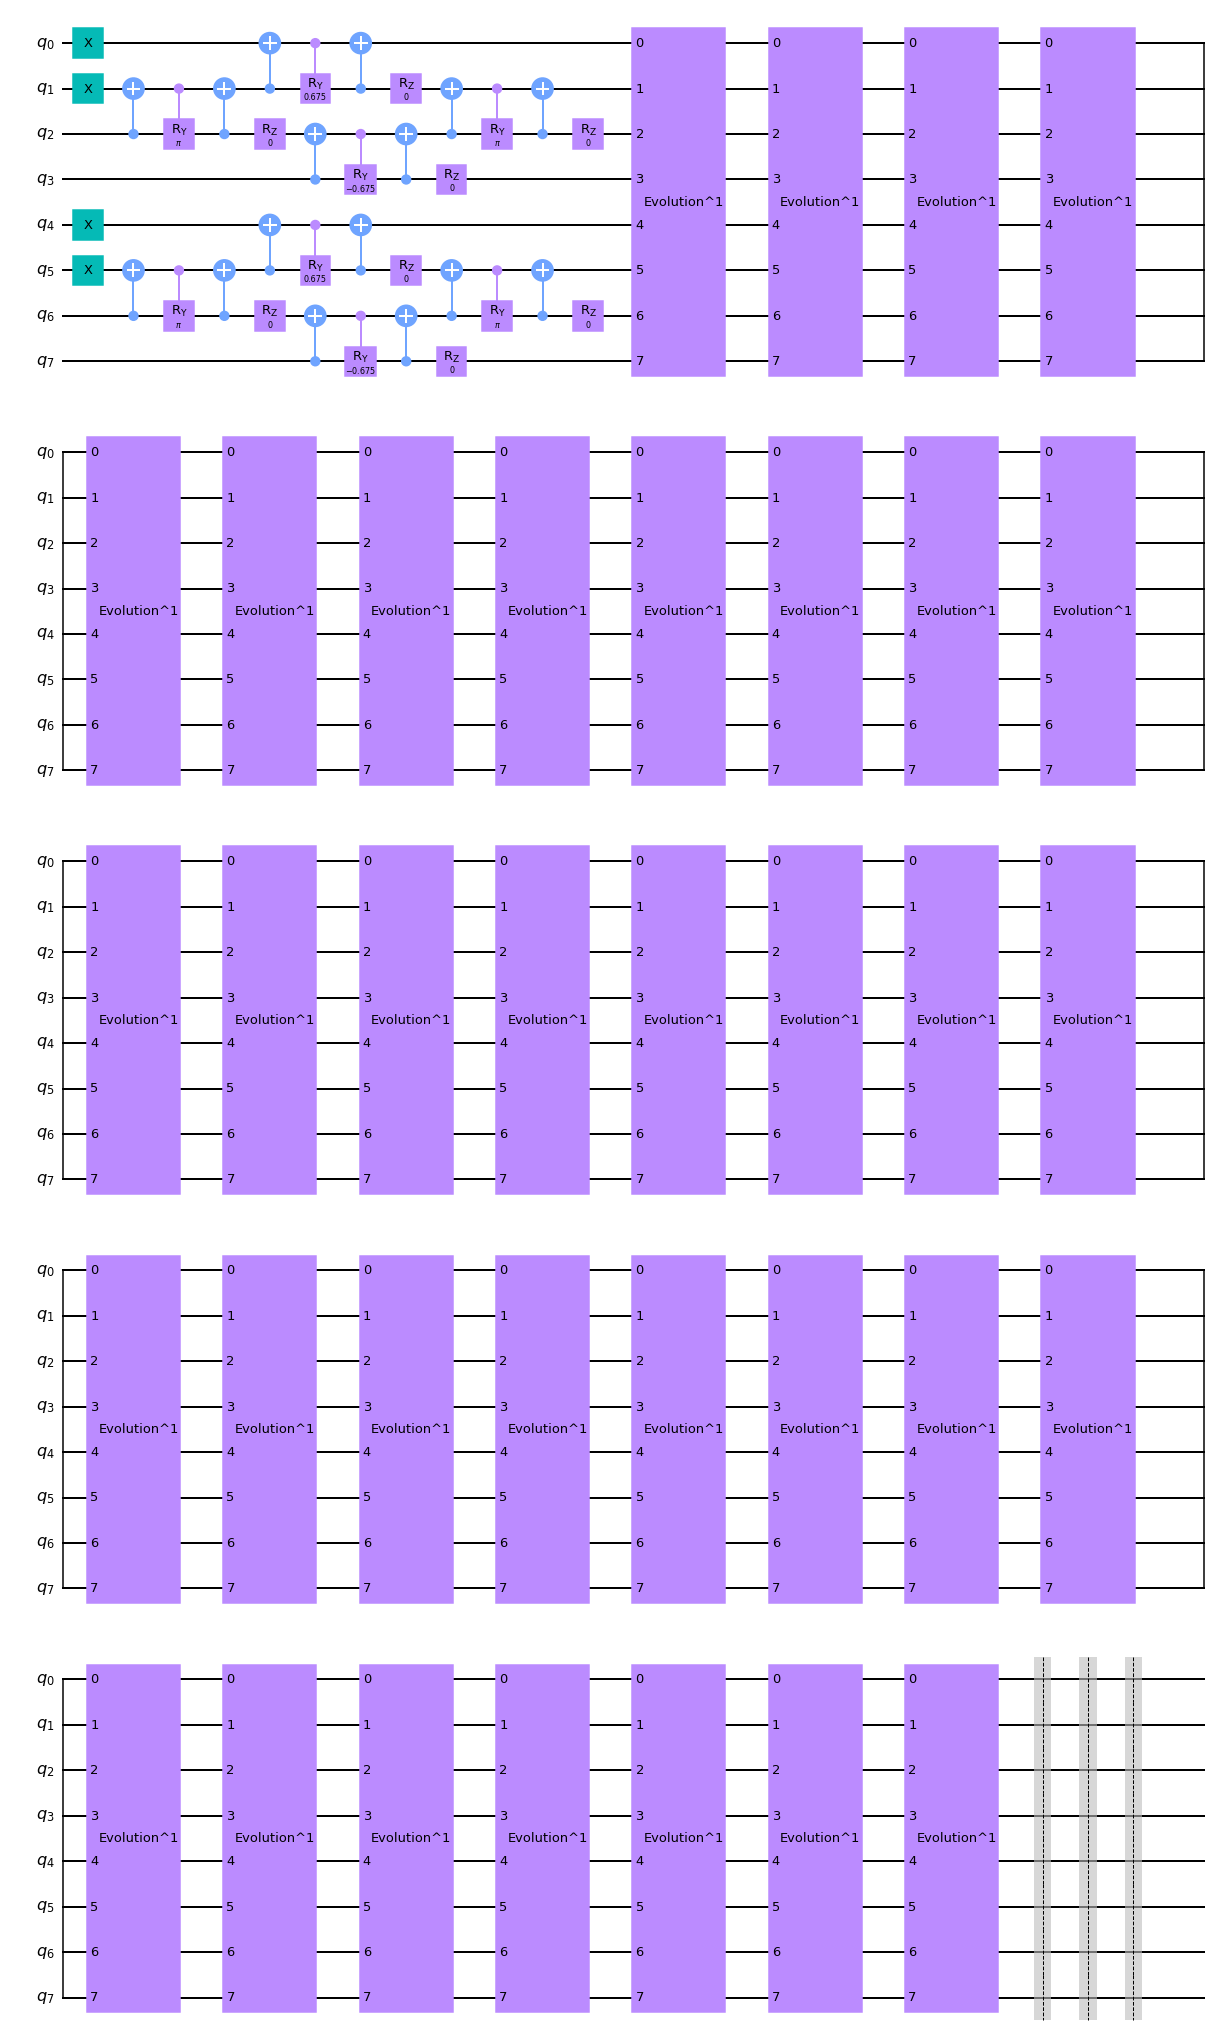

In [43]:
circ.save_density_matrix(label='density_matrix')


In [97]:
linear_fac = LinearFactory(scale_factors=[1.0,2.0,3.0])
linear_fac.run(compiled, Energy_Estimator, scale_noise=fold_gates_from_left)
zne_expval = linear_fac.reduce()

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   12.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    9.7s finished


In [127]:
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0, 4.0], order=2)
poly_fac.run(compiled, Energy_Estimator, scale_noise=fold_gates_from_left)
zne_expval=poly_fac.reduce()

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    7.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    8.5s finished


In [98]:
zne_expval

-19.20733084237425

In [99]:
linear_fac.get_expectation_values()

array([-19.08110595, -18.96097902, -18.83170515])

In [153]:
linear_fac.run(compiled, Energy_Estimator, scale_noise=fold_gates_from_right)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    8.7s finished


In [154]:
linear_fac.get_expectation_values()

array([-18.49907828, -18.00017154, -17.70378913])

In [38]:
richardson_fac.get_scale_factors()

array([1., 2., 3.])